In [1]:
import os
from keras.layers import Input, Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2

def network(input_window_size=60, filter_number=32, conv_window=(3,), pooling_window=(2,), dropout_rate=[],
            activation='relu', dense_activation='softmax', optimizer='adam', loss='categorical_crossentropy', layers=1):
    model = Sequential()
    
    # Input Layer
    model.add(Conv1D(filter_number, conv_window, activation=activation, padding='same', input_shape=(input_window_size, 1),
                     activity_regularizer=l2(0.001)))
    model.add(MaxPooling1D(pooling_window, padding='same'))
    model.add(Dropout(dropout_rate[0]))

    
    # Hidden Layers
    current_filter = 1
    filter_number_temp = filter_number
    for i in range(layers):
        filter_number_temp = filter_number_temp *  2
        model.add(Conv1D(filter_number_temp, conv_window, activation=activation, padding='same', 
                         activity_regularizer=l2(0.001)))
        model.add(MaxPooling1D(pooling_window, padding='same'))
        model.add(Dropout(dropout_rate[current_filter]))
        current_filter = current_filter + 1
    
    # Output Layer
    model.add(Flatten())
    model.add(Dense(2, activation=dense_activation))

    model.compile(optimizer=optimizer[0], loss=loss, metrics=['accuracy', 'categorical_accuracy'])

    return model

Using TensorFlow backend.


In [2]:
import os
import h5py
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


def rolling_window(a, window, step_size, padding=True, copy=True):
    if copy:
        result = a.copy()
    else:
        result = a
    if padding:
        result = np.hstack((result, np.zeros(window)))
    shape = result.shape[:-1] + (result.shape[-1] - window + 1 - step_size, window)
    strides = result.strides + (result.strides[-1] * step_size,)
    return np.lib.stride_tricks.as_strided(result, shape=shape, strides=strides)


size = 60

base_path = '/home/irene/Documents/Datos-Tesis/Training_window_set_1'

total_files = len(os.listdir(base_path))
x_dataset = np.zeros(shape=(0, size))
y_dataset = np.zeros(shape=(0, 1))
count = 1
skipped = []
for file_path in os.listdir(base_path):
    current_index = 0
    
    h5f = h5py.File(os.path.join(base_path, file_path), 'r')
    
    x = rolling_window(h5f['normal'][:], size, 1)
    y = rolling_window(h5f['transformed'][:], size, 1)
    y = [[np.amax(array)] for array in y]

    x_dataset = np.vstack((x_dataset, x))
    y_dataset = np.vstack((y_dataset, y))
    
    print(count)
    count = count + 1

x_dataset = np.reshape(x_dataset, (len(x_dataset), size, 1))
y_dataset = np.reshape(y_dataset, (len(y_dataset), 1))
y_dataset = to_categorical(y_dataset)

indices = np.arange(x_dataset.shape[0])
np.random.shuffle(indices)
x_dataset= x_dataset[indices] 
y_dataset= y_dataset[indices]

x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint, uniform
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

# Convert to scikit-learn model (build_fn is a function that returns a model)
model = KerasClassifier(build_fn=network)

# list of parameters
input_window_size = [60]
layers = [1]
filter_number = sp_randint(4, 32)
conv_window = [(3,), (5,)]
pooling_window = [(2,), (4,)]
activation = ['relu']
dense_activation = ['softmax', 'sigmoid']
optimizer = ['adam']
loss = ['categorical_crossentropy', 'binary_crossentropy']
dropout_rate = [uniform.rvs(0.0, 0.25, size = 5),
                uniform.rvs(0.0, 0.5, size = 5),
                uniform.rvs(0.0, 0.15, size = 5),
                uniform.rvs(0.0, 0.75, size = 5),
                uniform.rvs(0.0, 0.015, size = 5),
                uniform.rvs(0.0, 0.075, size = 5)]

epochs= sp_randint(30, 60)
batch_size = sp_randint(32, 128)

param_dist = dict(input_window_size=input_window_size,
                  filter_number=filter_number, 
                  conv_window=conv_window, 
                  pooling_window=pooling_window,
                  dropout_rate = dropout_rate,
                  activation=activation, 
                  dense_activation=dense_activation, 
                  optimizer=optimizer, 
                  loss=loss, 
                  layers=layers,
                  epochs=epochs,
                  batch_size=batch_size)

# Random Search
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=3, verbose=2, n_iter=64)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=3, verbose=2, n_iter=4, n_jobs=-1)
result = random_search.fit(x_train, y_train)


In [ ]:
# Show the results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
   print("%f (%f) with: %r" % (mean, stdev, param))

In [8]:
# Best: 0.992992 using {'pooling_window': (2,), 'optimizer': ('adam', 0), 'loss': 'binary_crossentropy', 'layers': 4, 'input_window_size': 60, 'filter_number': 32, 'epochs': 100, 'dropout_rate': [0.3, 0.4, 0.3, 0.3, 0.2, 0.5], 'dense_activation': 'sigmoid', 'conv_window': (5,), 'batch_size': 256, 'activation': 'relu'} 

cnn = network(layers=4, activation='relu', conv_window=(5,), dense_activation='sigmoid', dropout_rate= [0.3, 0.4, 0.3, 0.3, 0.2, 0.5], filter_number=32, input_window_size=60, loss='binary_crossentropy', optimizer=('adam', 0), pooling_window=(2,))

In [9]:
cnn.fit(x_train, y_train, epochs=100, batch_size=256)

Epoch 1/100
221471/221471 [==============================] - 345s 2ms/step - loss: 0.3257 - acc: 0.9398 - categorical_accuracy: 0.9396
Epoch 2/100
221471/221471 [==============================] - 344s 2ms/step - loss: 0.2396 - acc: 0.9405 - categorical_accuracy: 0.9405
Epoch 3/100
221471/221471 [==============================] - 344s 2ms/step - loss: 0.2109 - acc: 0.9405 - categorical_accuracy: 0.9405
Epoch 4/100
221471/221471 [==============================] - 344s 2ms/step - loss: 0.2010 - acc: 0.9406 - categorical_accuracy: 0.9406
Epoch 5/100
221471/221471 [==============================] - 344s 2ms/step - loss: 0.1929 - acc: 0.9440 - categorical_accuracy: 0.9440
Epoch 6/100
221471/221471 [==============================] - 344s 2ms/step - loss: 0.1883 - acc: 0.9468 - categorical_accuracy: 0.9468
Epoch 7/100
221471/221471 [==============================] - 347s 2ms/step - loss: 0.1843 - acc: 0.9486 - categorical_accuracy: 0.9486
Epoch 8/100
221471/221471 [============================

221471/221471 [==============================] - 338s 2ms/step - loss: 0.1648 - acc: 0.9552 - categorical_accuracy: 0.9552
Epoch 62/100
221471/221471 [==============================] - 338s 2ms/step - loss: 0.1658 - acc: 0.9549 - categorical_accuracy: 0.9549
Epoch 63/100
221471/221471 [==============================] - 344s 2ms/step - loss: 0.1643 - acc: 0.9553 - categorical_accuracy: 0.9553
Epoch 64/100
221471/221471 [==============================] - 347s 2ms/step - loss: 0.1636 - acc: 0.9557 - categorical_accuracy: 0.9557
Epoch 65/100
221471/221471 [==============================] - 346s 2ms/step - loss: 0.1643 - acc: 0.9550 - categorical_accuracy: 0.9550
Epoch 66/100
221471/221471 [==============================] - 342s 2ms/step - loss: 0.1648 - acc: 0.9551 - categorical_accuracy: 0.9551
Epoch 67/100
221471/221471 [==============================] - 341s 2ms/step - loss: 0.1661 - acc: 0.9549 - categorical_accuracy: 0.9549
Epoch 68/100
221471/221471 [==============================] -

In [3]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.core import read, UTCDateTime
from obspy.io.sac.util import get_sac_reftime
from obspy.signal.filter import lowpass, bandpass, highpass
import datetime


def picker_p_predict(file):
    p_is_defined = False
    tr = read(file)[0]

    tr.filter('bandpass', freqmin=1.0, freqmax=10.0, corners=4, zerophase=True)
    tr.normalize()
    if 'a' in tr.stats.sac and tr.stats.sac.a is not None: 
        picker_p = int(tr.stats.sac.a * tr.stats.sampling_rate)
        p_is_defined = True

    data = tr.data

    size = 60
    
    input_dataset = rolling_window(tr.data, size, 1)

    input_dataset = np.reshape(input_dataset, (len(input_dataset), size, 1))
    output = [x[1] for x in cnn.predict(input_dataset)]
    output_running_mean = running_mean(output, size)
    guess = np.argmax(output_running_mean)


    plt.figure(figsize=(50,10))
    plt.plot(tr.times(), data)

    if p_is_defined:
        plt.axvline(x=(picker_p*tr.stats.delta) , color='red')
        print("picker_p:", picker_p)
        
    plt.axvline(x=(guess*tr.stats.delta) , color='green', drawstyle ="steps-pre") 
    print("guess:", guess)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

#     plt.show()
    datetime_object = datetime.datetime.now()
    print(datetime_object)
    plt.savefig('/home/irene/Documents/Resultados/'+tr.stats.station+'_'+datetime_object.strftime('%m-%d-%Y::%H-%M')+'.png')

/home/irene/Documents/Datos-Tesis/Estaciones/PIRO.HHZ.2018.337.16.57.18.sac
guess: 15743
2019-06-05 09:13:36.174724
/home/irene/Documents/Datos-Tesis/Estaciones/DUNO.HHZ.2019.088.14.45.11
guess: 27
2019-06-05 09:13:43.412500
/home/irene/Documents/Datos-Tesis/Estaciones/VRBA.HHZ.2019.088.14.45.11
guess: 117221
2019-06-05 09:13:50.210077
/home/irene/Documents/Datos-Tesis/Estaciones/BATAN.HHZ.2018.337.16.57.18.sac
guess: 34166
2019-06-05 09:13:54.028245
/home/irene/Documents/Datos-Tesis/Estaciones/VRLE.HHZ.2019.088.14.45.11
guess: 58349
2019-06-05 09:14:00.657291
/home/irene/Documents/Datos-Tesis/Estaciones/ORTG.HHZ.2019.088.14.45.11
guess: 62558
2019-06-05 09:14:07.289291


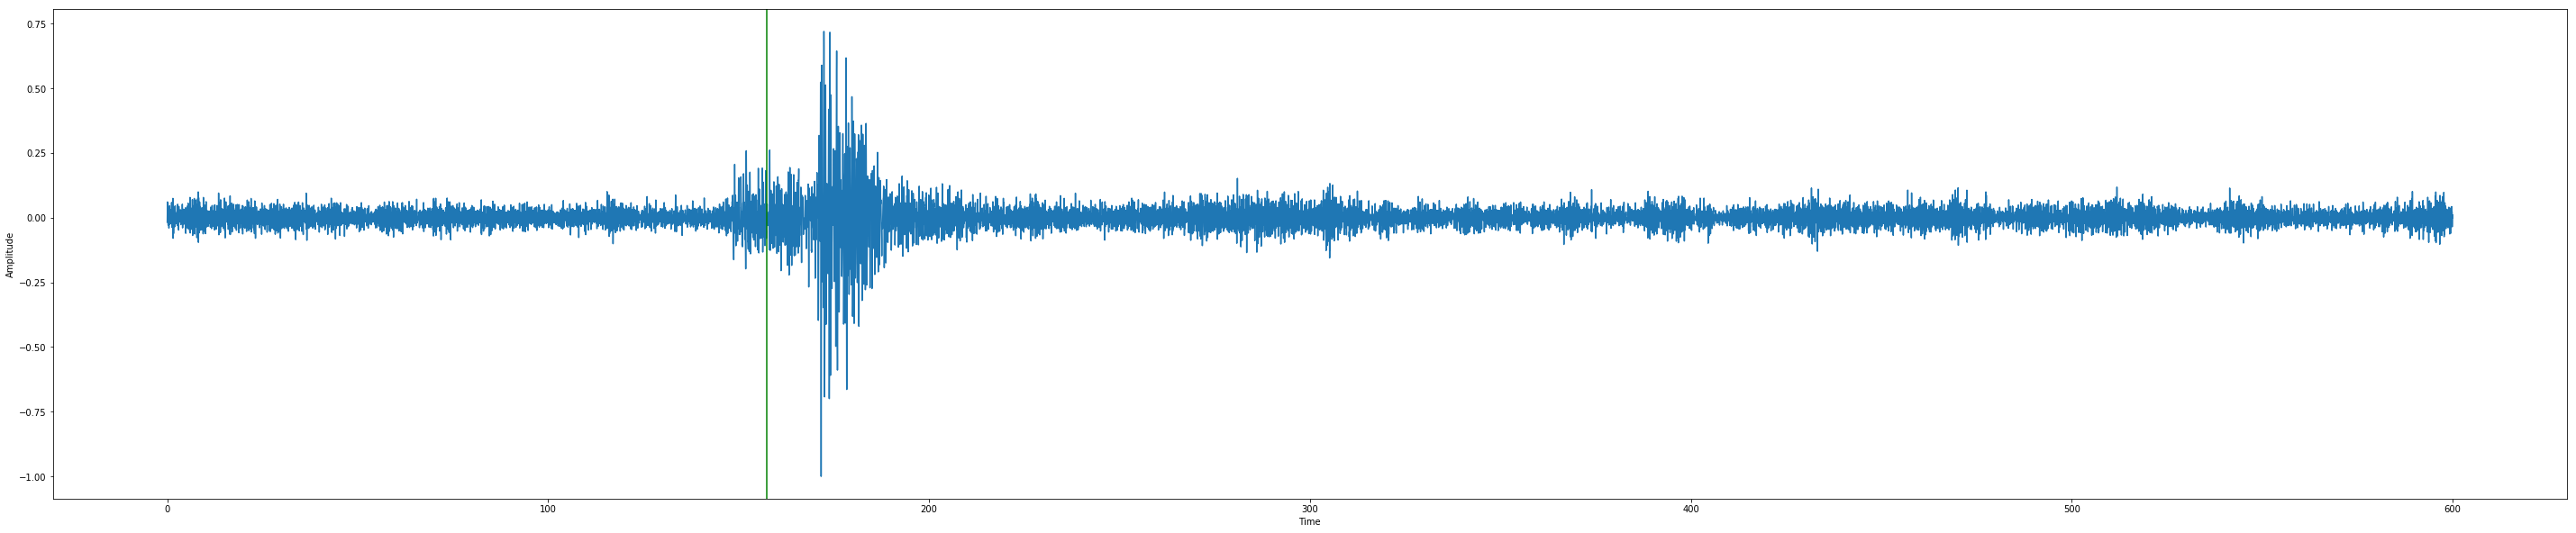

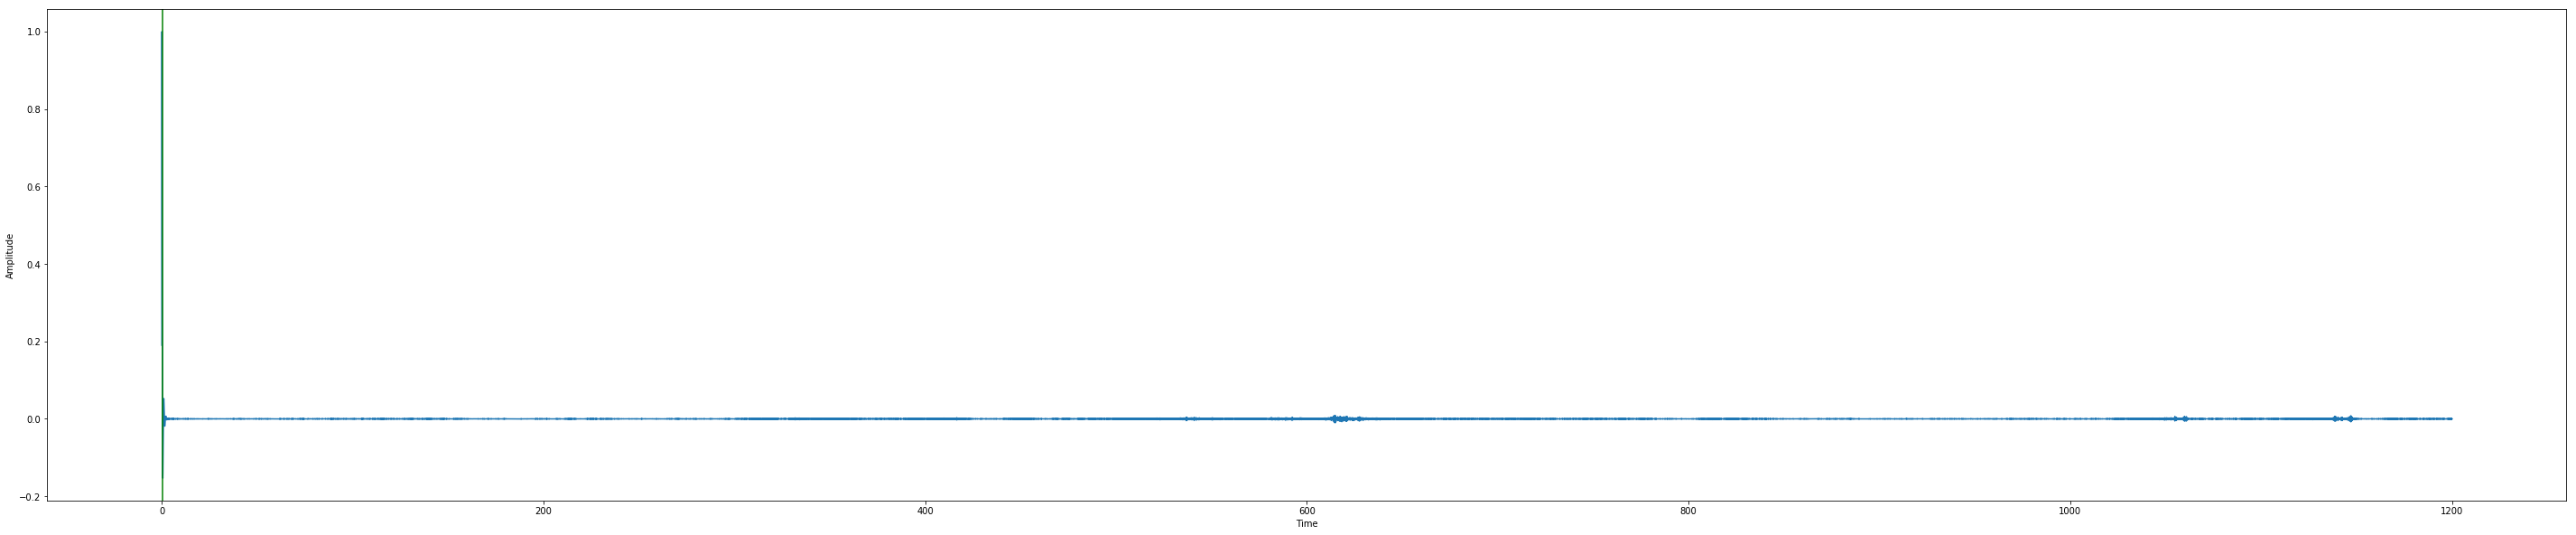

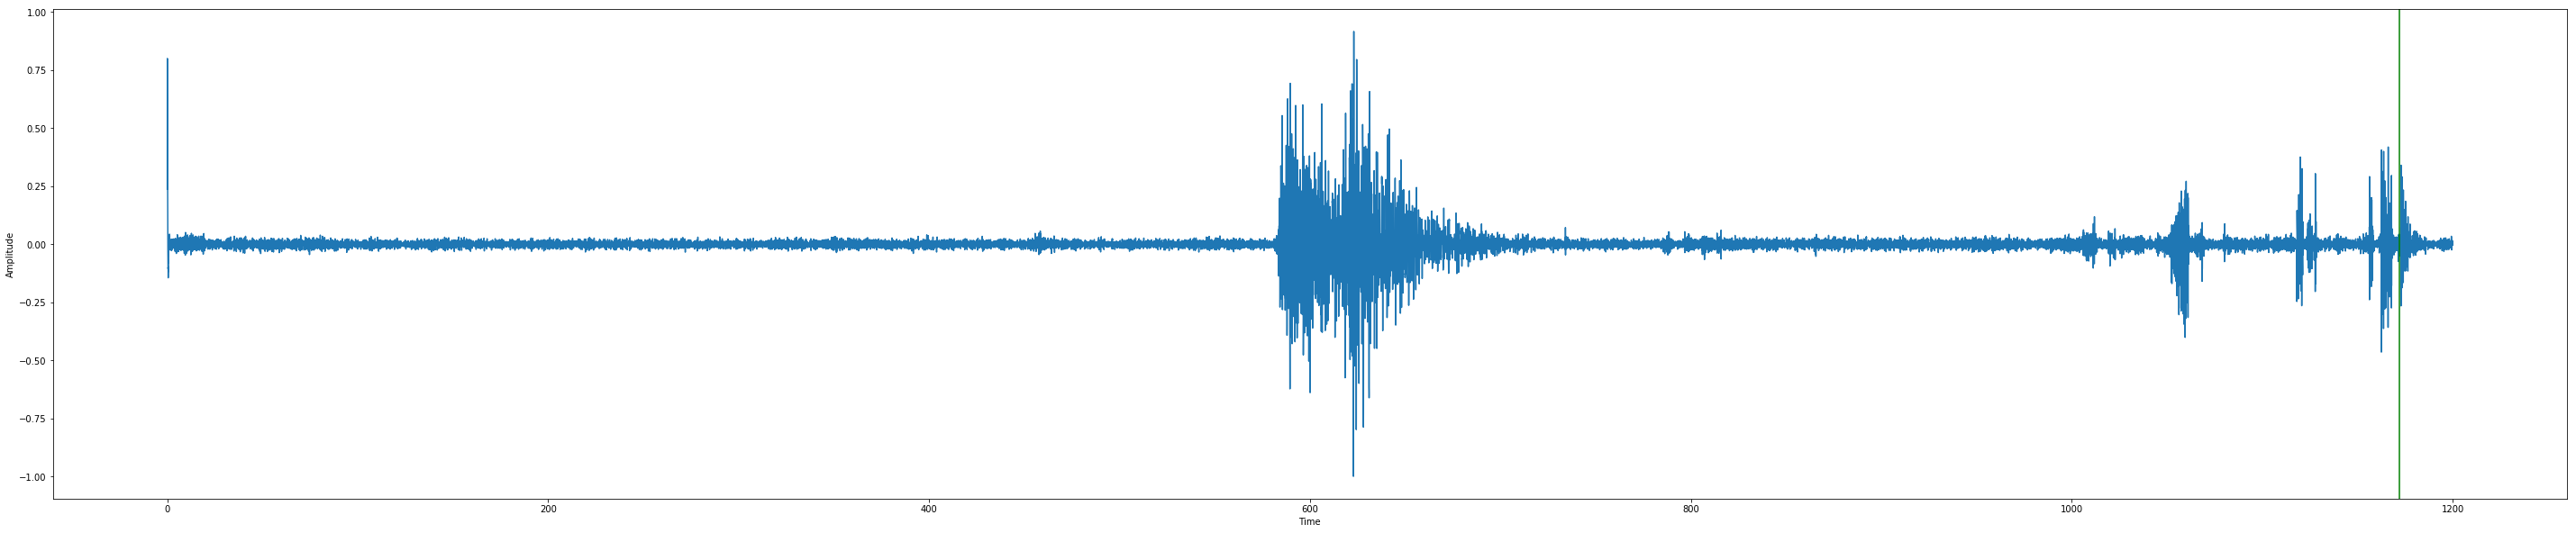

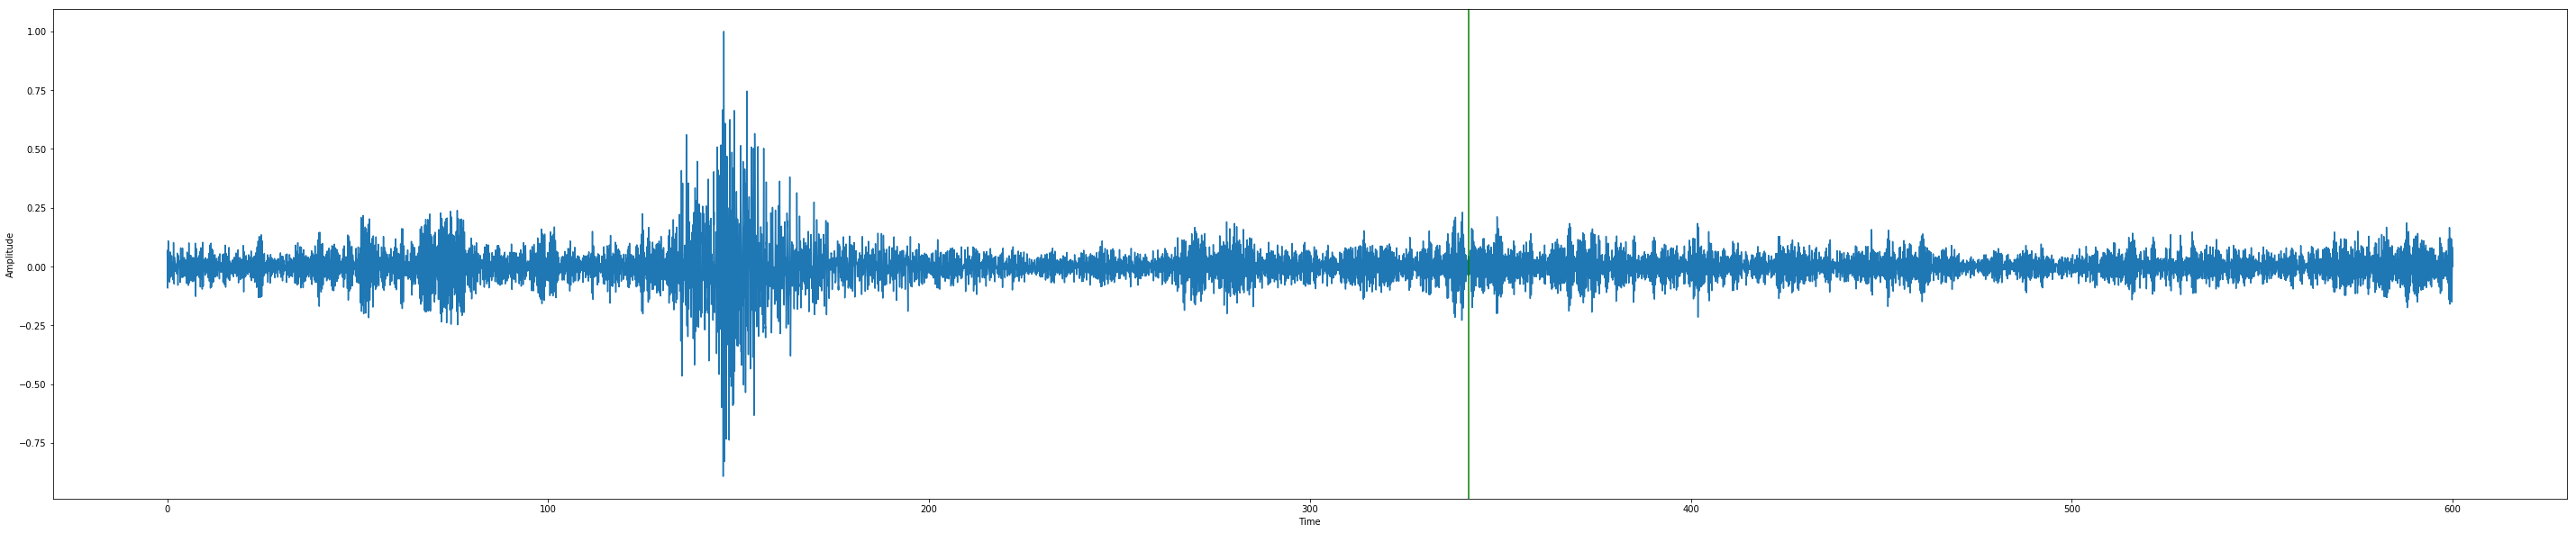

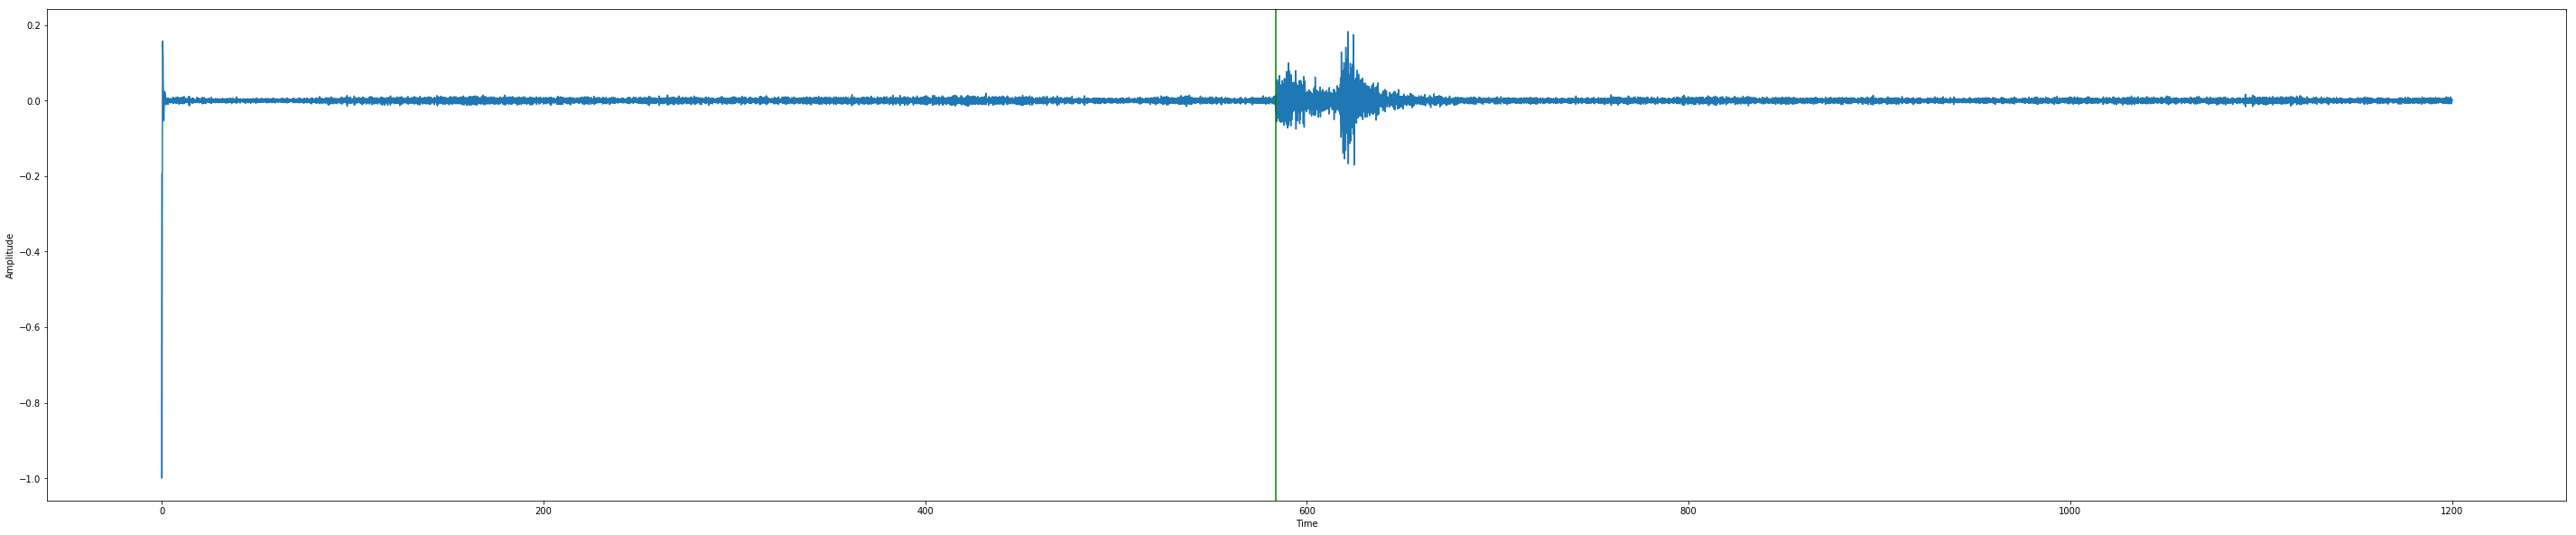

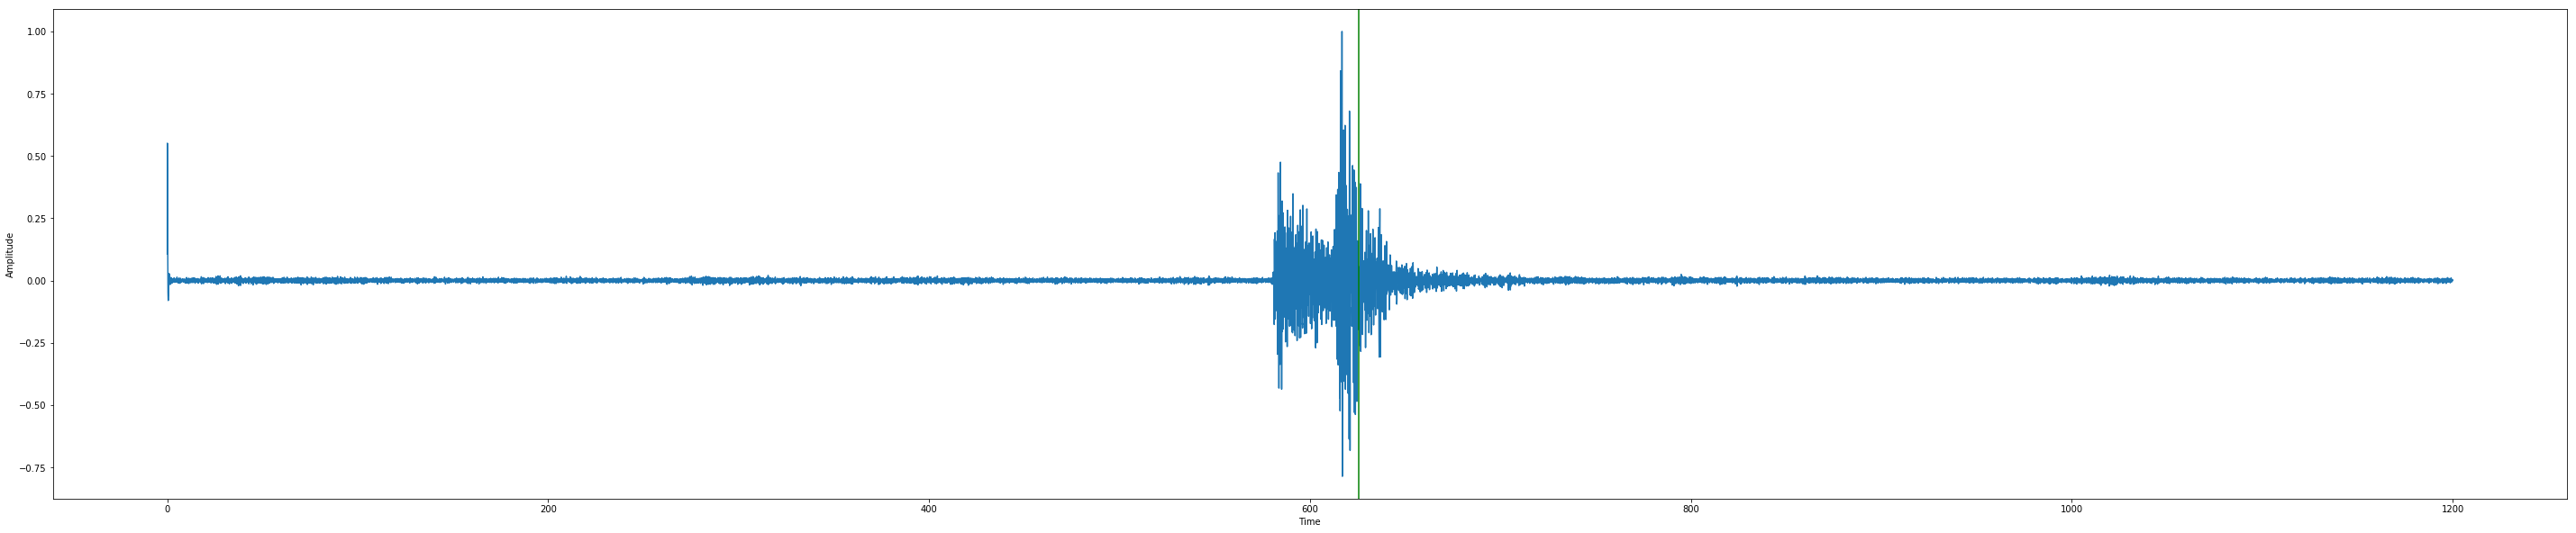

In [7]:
import os 

base_path = '/home/irene/Documents/Datos-Tesis/Estaciones/'

files_name = ["PIRO.HHZ.2018.337.16.57.18.sac","DUNO.HHZ.2019.088.14.45.11","VRBA.HHZ.2019.088.14.45.11",
              "BATAN.HHZ.2018.337.16.57.18.sac","VRLE.HHZ.2019.088.14.45.11","ORTG.HHZ.2019.088.14.45.11"]
for file_name in files_name:
    file = os.path.join(base_path, file_name)
    print(file)
    picker_p_predict(file)